In [1]:
RunInColab = 'google.colab' in str(get_ipython())
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

#Installing missing packages
'''!pip install optuna
!pip install catboost
!pip install xgboost
!pip install lightgbm'''
!pip install roman

#Imports
import os
import stat
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import optuna
import time
import importlib
import json
#import torch
#import lightgbm
#torch.autograd.set_detect_anomaly(False)
#torch.set_default_tensor_type(torch.DoubleTensor)
#torch.set_default_dtype(torch.float64)

#Importing sklearn models and metrics
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm
from sklearn.preprocessing import StandardScaler

#Importing TabNet Regressor model    
#from pytorch_tabnet.tab_model import  TabNetRegressor

np.random.seed(777)

#import pytorch_tabnet
#os.environ['tabnet'] = pytorch_tabnet.__path__.__dict__['_path'][0]
#os.environ['patchfile'] = os.path.abspath(os.path.join('Stark_ML', 'float64.patch'))
#if os.name == 'nt':
#    !cd /d %tabnet% & patch < "%patchfile%"
#else:
#    !cd $tabnet && patch -f < $patchfile
#importlib.reload(pytorch_tabnet)

if RunInColab:
    from google.colab import output
    def clear_output():
        output.clear()
else:
    from IPython import display
    def clear_output():
        display.clear_output()

clear_output()

In [2]:
#Download and import all utilities and models

import Stark_ML
import Stark_ML.utils.optuning
import Stark_ML.models.base_models
import Stark_ML.utils.metrics
import Stark_ML.utils.terms
import Stark_ML.utils.testset
import Stark_ML.utils.plotting
import Stark_ML.models.tabnet

importlib.reload(Stark_ML.models.base_models)
importlib.reload(Stark_ML.utils.optuning)
importlib.reload(Stark_ML.utils.metrics)
importlib.reload(Stark_ML.utils.plotting)
importlib.reload(Stark_ML.models.tabnet)

from Stark_ML.models.base_models import *
from Stark_ML.utils.optuning import *
from Stark_ML.utils.metrics import *
from Stark_ML.utils.terms import *
from Stark_ML.utils.testset import *
from Stark_ML.utils.plotting import *
from Stark_ML.models.tabnet import *
from Stark_ML.utils import *
#from pytorch_tabnet.tab_model import  TabNetRegressor
clear_output()

# Ions data

In [17]:
#Import data for training and testing
data_a = pd.read_excel(Stark_ML.__path__.__dict__['_path'][0] + '/Source_files/Stark_data.xlsx',
                     sheet_name='Experimental',
                     usecols='A:BF'
                   )
#Replace term symbols with quantum numbers
data_a['Term'] = term_to_number(data_a['Term'])
data_a['Term.1'] = term_to_number(data_a['Term.1'])

#Replace accuracy symbols with uncetrainty in %
data_a['w error (%)'] = uncertainty_to_number(data_a[data_a['w error (%)'].notna()]['w error (%)'])
data_a['d error (%)'] = uncertainty_to_number(data_a[data_a['d error (%)'].notna()]['d error (%)'])

In [18]:
#Import ions data for training and testing
data_i = pd.read_excel(Stark_ML.__path__.__dict__['_path'][0] + '/Source_files/Stark_data.xlsx',
                     sheet_name='Ions',
                     usecols='A:BR'
                   )
#Replace term symbols with quantum numbers
data_i['Term'] = term_to_number(data_i['Term'])
data_i['Term.1'] = term_to_number(data_i['Term.1'])

#Replace accuracy symbols with uncetrainty in %
data_i['w error (%)'] = uncertainty_to_number(data_i[data_i['w error (%)'].notna()]['w error (%)'])
data_i['d error (%)'] = uncertainty_to_number(data_i[data_i['d error (%)'].notna()]['d error (%)'])

#Drop entries with levels' data unavailable
data_i = data_i[data_i['J'].notna()]
data_i = data_i[data_i['J.1'].notna()]

In [19]:
#Making sure that atoms and ions datasets have the same set of columns
for i, name in enumerate(data_i.columns):
    if name != data_a.columns[i]:
        if name in data_a.columns:
            print(f'renaming {name}')
            data_a = data_a.rename(columns = {name: name+'.1'})
        data_a.insert(i, data_i.columns[i], 0)
        print(data_i.columns[i])

Charge
5f
5g
renaming 6d
6d
renaming 7p
7p
renaming 7d
7d
5f.1
5g.1
6f
6g
6h
11s


In [20]:
#merging atoms and ions together
data = pd.concat([data_a, data_i], axis = 0, ignore_index = True)
data.insert(data.columns.get_loc('E upper')+1, 'Gap to ion', 0)
data['Gap to ion'] = gap_to_ion(data, 'E upper')

In [21]:
data_width = data[data['w (A)'].isna() == False]
data_shift = data[data['d (A)'].isna() == False]
data_both = data[(data['w (A)'].isna() == False) & (data['d (A)'].isna() == False)]

## Chemical elements

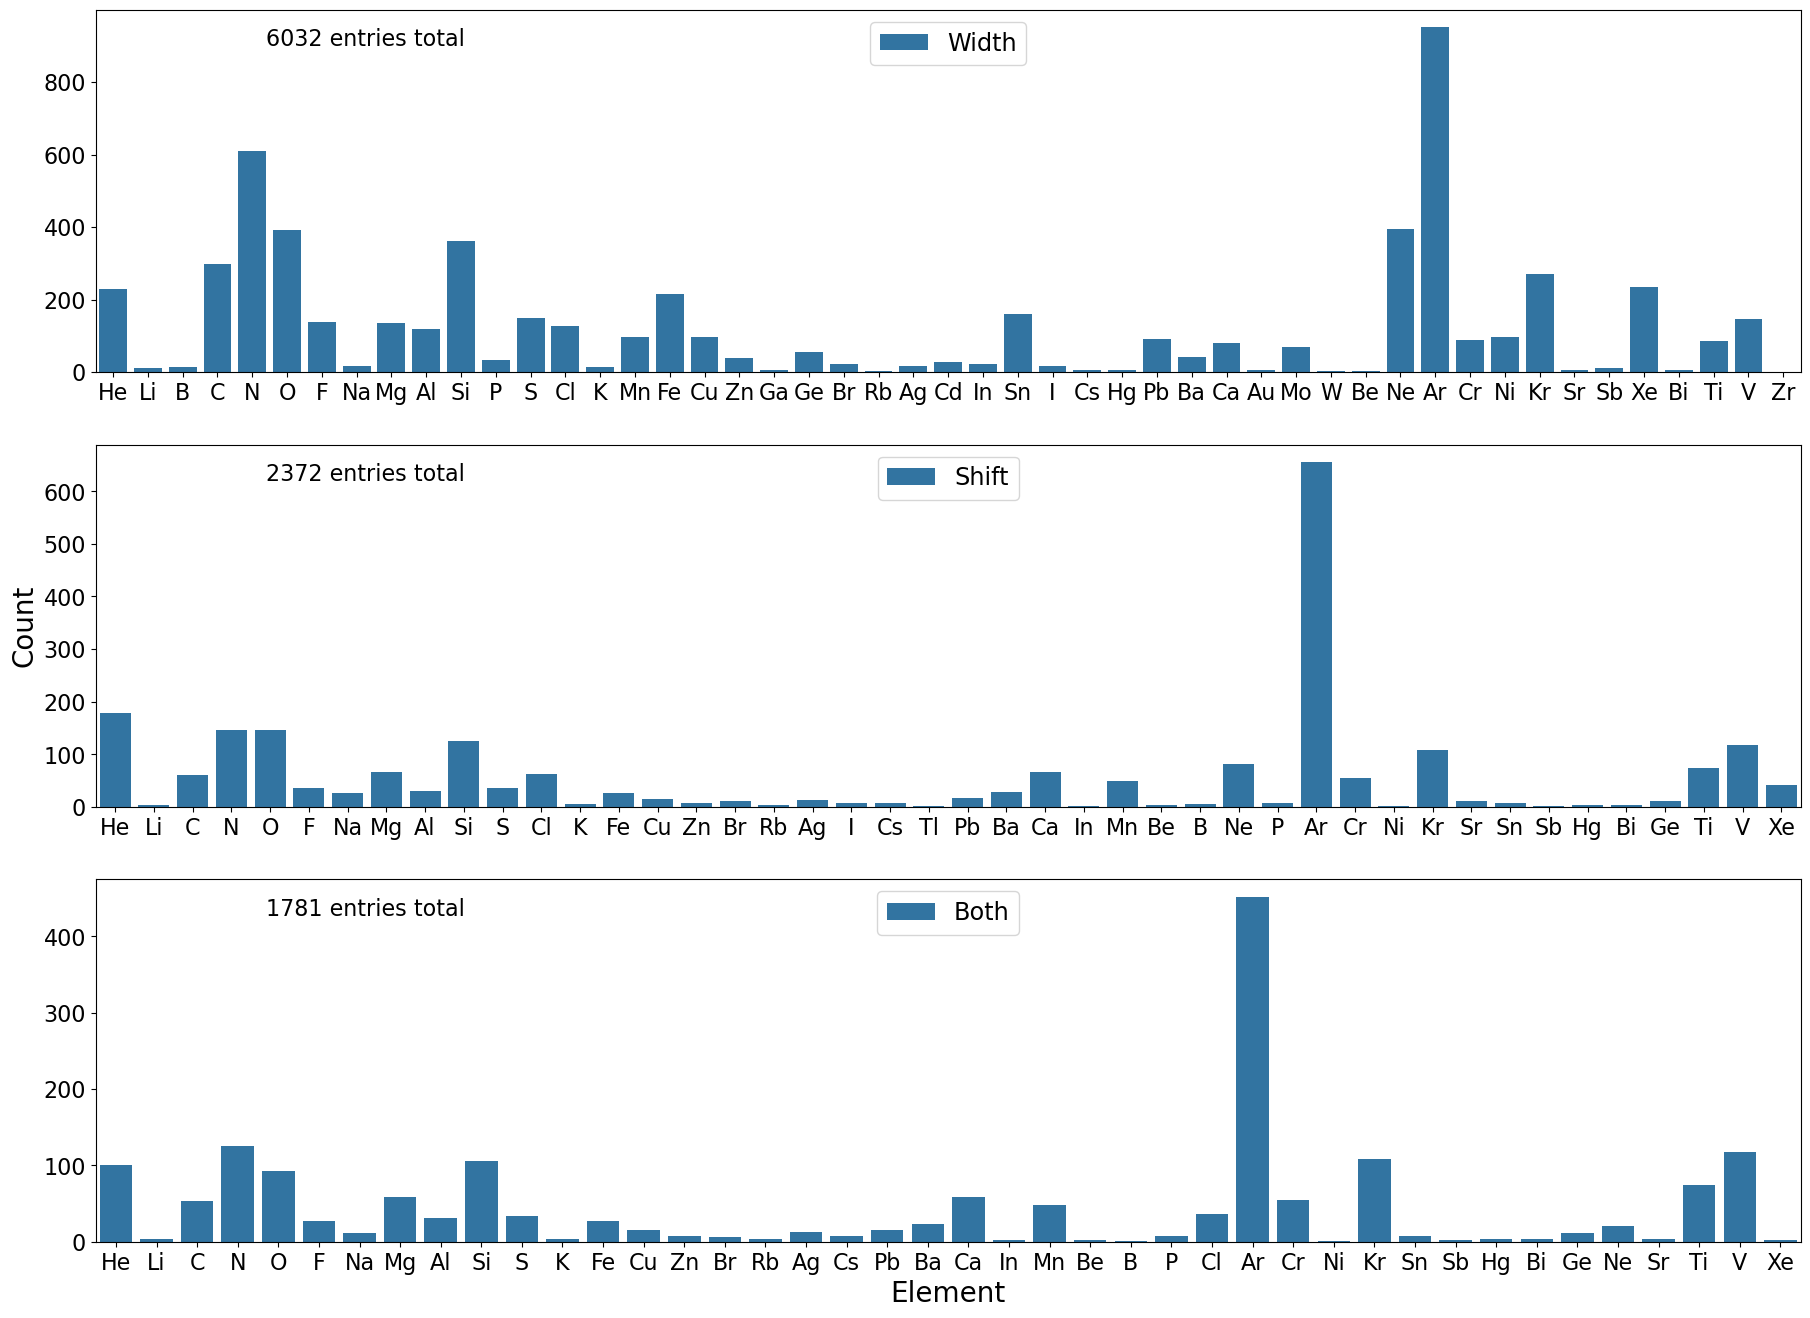

In [9]:
fig, ax = plt.subplots(3, 1, figsize = (22, 16), sharex = False)
sns.countplot(data = data_width, x = 'Element', ax = ax[0], label = 'Width')
sns.countplot(data = data_shift, x = 'Element', ax = ax[1], label = 'Shift')
sns.countplot(data = data_both, x = 'Element', ax = ax[2], label = 'Both')

for i in range(len(ax)):
    ax[i].legend(loc = 'upper center', fontsize = 'xx-large')
    ax[i].tick_params(axis = 'both', labelsize = 16)
    ax[i].set_xlabel(None)
    ax[i].set_ylabel(None)

ax[0].text(x = 0.1, y = 0.9, s = f'{data_width.shape[0]} entries total', transform=ax[0].transAxes, fontsize = 16)
ax[1].text(x = 0.1, y = 0.9, s = f'{data_shift.shape[0]} entries total', transform=ax[1].transAxes, fontsize = 16)
ax[2].text(x = 0.1, y = 0.9, s = f'{data_both.shape[0]} entries total', transform=ax[2].transAxes, fontsize = 16)
ax[2].set_xlabel('Element', fontsize = 20)
ax[1].set_ylabel('Count', fontsize = 20)
plt.show()

## Charges

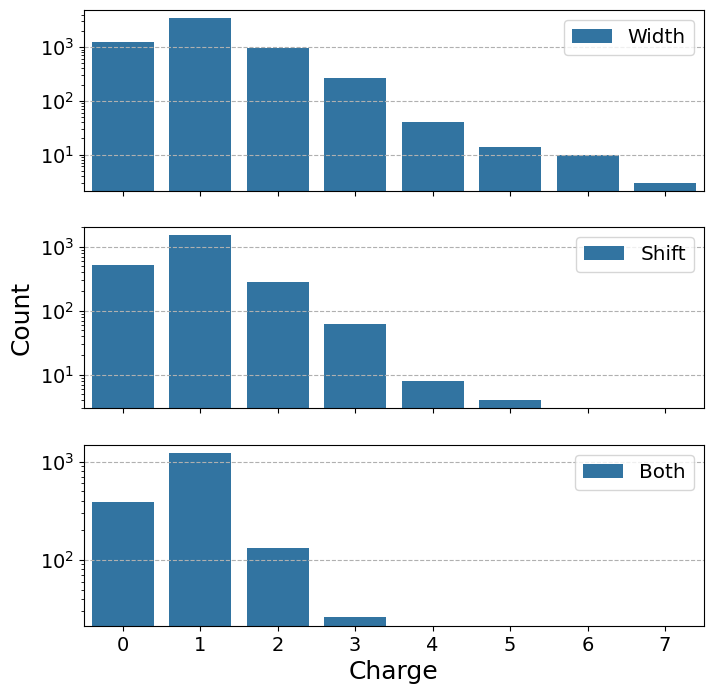

In [31]:
fig, ax = plt.subplots(3, 1, figsize = (8, 8), sharex = True)
sns.countplot(data = data_width, x = 'Charge', ax = ax[0], label = 'Width', log_scale = False)
sns.countplot(data = data_shift, x = 'Charge', ax = ax[1], label = 'Shift')
sns.countplot(data = data_both, x = 'Charge', ax = ax[2], label = 'Both')

for i in range(len(ax)):
    ax[i].legend(loc = 'upper right', fontsize = 'x-large')
    ax[i].tick_params(axis = 'both', labelsize = 14)
    ax[i].set_xlabel(None)
    ax[i].set_ylabel(None)

ax[2].set_xlabel('Charge', fontsize = 18)
ax[1].set_ylabel('Count', fontsize = 18)

ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')

ax[0].grid(which = 'major', axis = 'y', ls = '--')
ax[1].grid(which = 'major', axis = 'y', ls = '--')
ax[2].grid(which = 'major', axis = 'y', ls = '--')
plt.show()

## Energies

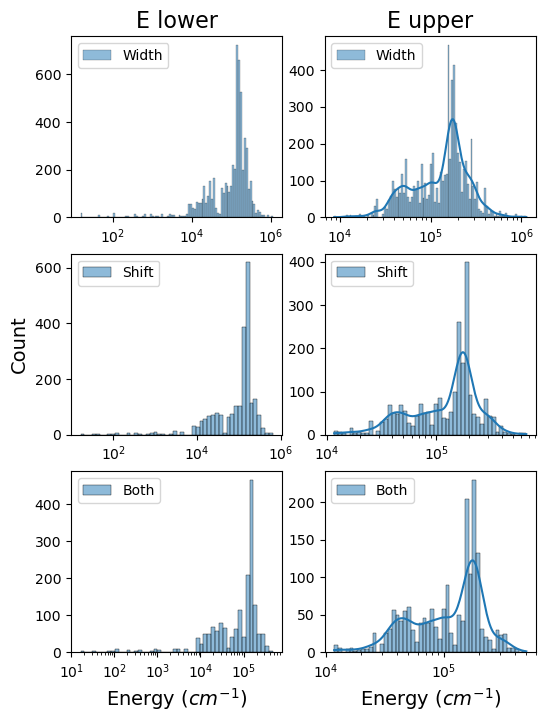

In [96]:
fig, ax = plt.subplots(3, 2, figsize = (6, 8))

sns.histplot(data = data_width, x = 'E lower', ax = ax[0, 0], log_scale=True, bins = 100, kde = True, label = 'Width')
sns.histplot(data = data_width, x = 'E upper', ax = ax[0, 1], log_scale=True, bins = 100, kde = True, label = 'Width')
sns.histplot(data = data_shift, x = 'E lower', ax = ax[1, 0], log_scale=True, bins = 50, kde = True, label = 'Shift')
sns.histplot(data = data_shift, x = 'E upper', ax = ax[1, 1], log_scale=True, bins = 50, kde = True, label = 'Shift')
sns.histplot(data = data_both,  x = 'E lower', ax = ax[2, 0], log_scale=True, bins = 50, kde = True, label = 'Both')
sns.histplot(data = data_both,  x = 'E upper', ax = ax[2, 1], log_scale=True, bins = 50, kde = True, label = 'Both')

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        ax[i, j].set_xlabel(None)
        ax[i, j].set_ylabel(None)
        ax[i, j].legend()
        
ax[2, 0].set_xlabel('Energy ($cm^{-1}$)', fontsize = 14)
ax[2, 1].set_xlabel('Energy ($cm^{-1}$)', fontsize = 14)
ax[1, 0].set_ylabel('Count', fontsize = 14)

ax[0, 0].set_title('E lower', fontsize = 16)
ax[0, 1].set_title('E upper', fontsize = 16)
plt.show()

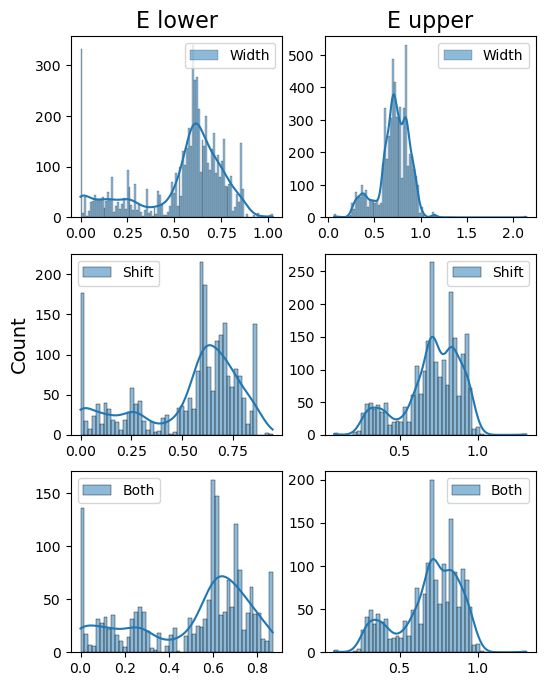

In [22]:
data_width_fraction = data_width.copy()
data_shift_fraction = data_shift.copy()
data_both_fraction  = data_both.copy()

data_width_fraction['E lower'], data_width_fraction['E upper'] = energy_to_fraction(data_width_fraction, 'E lower'), energy_to_fraction(data_width_fraction, 'E upper')
data_shift_fraction['E lower'], data_shift_fraction['E upper'] = energy_to_fraction(data_shift_fraction, 'E lower'), energy_to_fraction(data_shift_fraction, 'E upper')
data_both_fraction['E lower'], data_both_fraction['E upper']   = energy_to_fraction(data_both_fraction, 'E lower'), energy_to_fraction(data_both_fraction, 'E upper')

fig, ax = plt.subplots(3, 2, figsize = (6, 8))

sns.histplot(data = data_width_fraction, x = 'E lower', ax = ax[0, 0], log_scale=False, bins = 100, kde = True, label = 'Width')
sns.histplot(data = data_width_fraction, x = 'E upper', ax = ax[0, 1], log_scale=False, bins = 100, kde = True, label = 'Width')
sns.histplot(data = data_shift_fraction, x = 'E lower', ax = ax[1, 0], log_scale=False, bins = 50, kde = True, label = 'Shift')
sns.histplot(data = data_shift_fraction, x = 'E upper', ax = ax[1, 1], log_scale=False, bins = 50, kde = True, label = 'Shift')
sns.histplot(data = data_both_fraction,  x = 'E lower', ax = ax[2, 0], log_scale=False, bins = 50, kde = True, label = 'Both')
sns.histplot(data = data_both_fraction,  x = 'E upper', ax = ax[2, 1], log_scale=False, bins = 50, kde = True, label = 'Both')

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        ax[i, j].set_xlabel(None)
        ax[i, j].set_ylabel(None)
        ax[i, j].legend()
        
#ax[2, 0].set_xlabel('Energy ($cm^{-1}$)', fontsize = 14)
#ax[2, 1].set_xlabel('Energy ($cm^{-1}$)', fontsize = 14)
ax[1, 0].set_ylabel('Count', fontsize = 14)

ax[0, 0].set_title('E lower', fontsize = 16)
ax[0, 1].set_title('E upper', fontsize = 16)
plt.show()

In [41]:
data_width_fraction.loc[(data_width_fraction['E upper'] >= 1) & (data_width_fraction['Element'] == 'Si')][['Element', 'Charge', 'Wavelength', 'E lower', 'E upper']]

,Element,Charge,Wavelength,E lower,E upper
1317,Si,0,206.119,0.506876,1.244543
2651,Si,1,419.072,0.825411,1.006358
2652,Si,1,419.813,0.825094,1.005720
2653,Si,1,570.137,0.867179,1.000182
2655,Si,1,568.881,0.867842,1.001138
2678,Si,1,586.840,0.888803,1.018019
5342,Si,1,566.956,0.868711,1.002460
5343,Si,1,419.813,0.825094,1.005720
6409,Si,1,566.956,0.868711,1.002460
6410,Si,1,566.956,0.868711,1.002460


In [104]:
data_width

,Element,Wavelength,Z number,Charge,1s,2s,2p,3s,3p,3d,...,Term.1,Parity.1,J.1,E upper,Gap to ion,T,w (A),d (A),w error (%),d error (%)
0,He,2058.130,2,0,1,1,0,0,0,0,...,1,0,1.0,171134.896946,27176.103054,24400,15.324675,NaN,NaN,NaN
1,He,2058.130,2,0,1,1,0,0,0,0,...,1,0,1.0,171134.896946,27176.103054,25500,12.967033,NaN,NaN,NaN
2,He,2058.130,2,0,1,1,0,0,0,0,...,1,0,1.0,171134.896946,27176.103054,25500,11.515152,NaN,NaN,NaN
3,He,501.568,2,0,1,1,0,0,0,0,...,1,0,1.0,186209.364940,12101.635060,19000,8.800000,NaN,NaN,NaN
4,He,501.568,2,0,1,1,0,0,0,0,...,1,0,1.0,186209.364940,12101.635060,19100,8.042553,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6619,N,500.515,7,1,2,2,1,0,1,0,...,3,0,4.0,186652.490000,52097.510000,30300,0.325581,NaN,23.0,NaN
6620,N,500.147,7,1,2,2,1,0,1,0,...,3,0,3.0,186570.980000,52179.020000,30300,0.331395,NaN,23.0,NaN
6621,N,500.113,7,1,2,2,1,0,1,0,...,3,0,2.0,186511.580000,52238.420000,30300,0.302326,NaN,23.0,NaN
6622,N,501.638,7,1,2,2,1,0,1,0,...,3,0,2.0,186511.580000,52238.420000,30300,0.337209,NaN,23.0,NaN


In [103]:
a.describe()


count    6032.000000
mean        0.712409
std         0.171189
min         0.064867
25%         0.635473
50%         0.722839
75%         0.835391
max         2.141998
dtype: float64

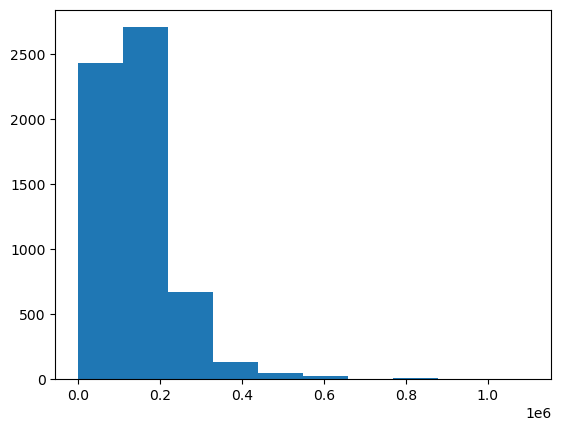

In [48]:
n, bins, patches = plt.hist(data_width['E lower'])

In [40]:
data_width['E lower'].describe()

count    6.032000e+03
mean     8.938820e+05
std      3.420179e+07
min      0.000000e+00
25%      3.561162e+04
50%      1.346674e+05
75%      1.711349e+05
max      1.597065e+09
Name: E lower, dtype: float64

In [71]:
!pip install seaborn==0.13.0

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/294.6 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.6 kB ? eta -:--:--
   ------------ --------------------------- 92.2/294.6 kB 1.3 MB/s eta 0:00:01
   -------------------------------------- - 286.7/294.6 kB 3.0 MB/s eta 0:00:01
   ---------------------------------------- 294.6/294.6 kB 2.3 MB/s eta 0:00:00


In [75]:
!pip list

Package              Version
-------------------- ------------
alembic              1.13.1
anyio                3.5.0
argon2-cffi          21.3.0
argon2-cffi-bindings 21.2.0
asteval              0.9.31
asttokens            2.0.5
attrs                23.1.0
backcall             0.2.0
beautifulsoup4       4.12.2
bleach               4.1.0
Bottleneck           1.3.5
Brotli               1.0.9
catboost             1.2.2
certifi              2023.7.22
cffi                 1.15.1
charset-normalizer   2.0.4
colorama             0.4.6
colorlog             6.8.0
comm                 0.2.0
contourpy            1.0.5
cryptography         41.0.3
cycler               0.11.0
debugpy              1.6.7
decorator            5.1.1
defusedxml           0.7.1
entrypoints          0.4
et-xmlfile           1.1.0
executing            0.8.3
fastjsonschema       2.16.2
filelock             3.9.0
fonttools            4.25.0
fsspec               2023.12.2
graphviz             0.20.1
greenlet             3.0.3
i